# Quantidade de Dados:

- Eu tenho os recursos corretos para trabalhar?
    - Servidores?Clusters? Spark? Hadoop?

# Tipos de Variáveis:

- Quais os tipos de variáveis?
    - % Numérica, % Categórica, % Temporal.

# Quantidade de Dados Faltante:

- Qual o volume de dados NA?
- Qual a razão de faltar dados?
    - Sistema? Imput Manual?

# Resumo Geral dos Dados

- Estatística Descritiva.

# 0.0 IMPORTS

In [27]:
import math
import numpy as np
import pandas as pd
import inflection
import seaborn as sns

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from scipy import stats as ss
from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML
from tabulate import tabulate

## 0.1 Heper Functions

In [28]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, c = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (c-1) * (r-1) / (n-1))

    ccorr = c - (c-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt( ( chi2corr/n ) / (min(ccorr-1, rcorr-1)) )

In [29]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [30]:
df_sales_raw = pd.read_csv('./../datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('./../datasets/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 DESCRIÇÃO DOS DADOS

In [31]:
df1 = df_raw.copy()

## 1.1 Rename Coumns

In [32]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map (snakecase, cols_old))

df1.columns = cols_new

## 1.2 Data Dimensions

In [33]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data types 

In [34]:
df1['date'] = pd.to_datetime(df1['date'], format='%Y-%m-%d')
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA 

In [35]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [36]:
# competition_distance (Assumindo que não tem competidor proximo colocando o maior possivel de distancia)
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200_000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct',11: 'Nov',12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


## 1.6 Change Types

In [37]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [38]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerial Attributes

In [39]:
# Central Tendency - mean, median
_mean = pd.DataFrame( num_attributes.apply( np.mean ) ).T
_median = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
_std = pd.DataFrame( num_attributes.apply( np.std ) ).T
_min = pd.DataFrame( num_attributes.apply( min ) ).T
_max = pd.DataFrame( num_attributes.apply( max ) ).T
_range = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
_skew = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
_kurtosis = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [_min, _max, _range, _mean, _median, _std, _skew, _kurtosis] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] 
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.155231,0.0,0.362124,1.904152,1.625796


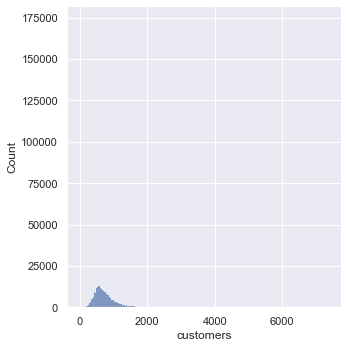

In [40]:
sns.displot(df1['customers']);

### 1.7.2 Categorical Attributes

In [41]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

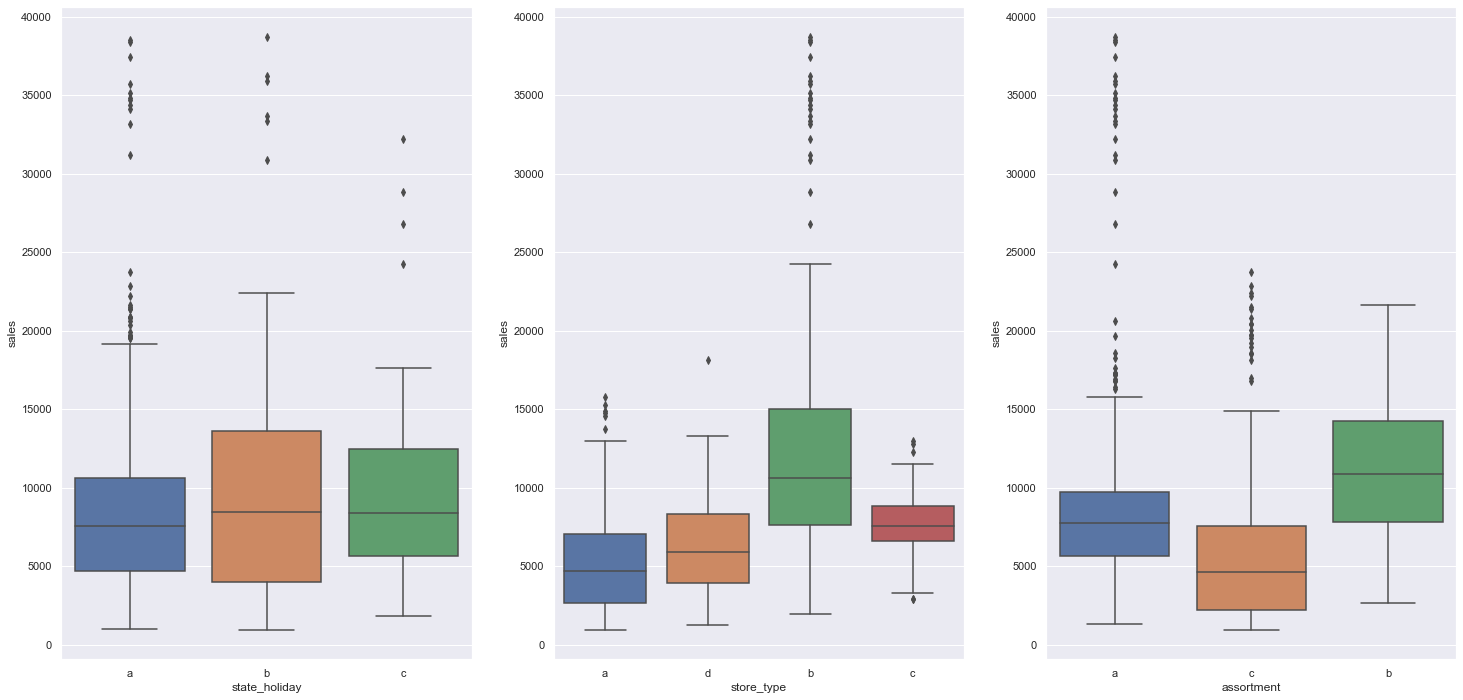

In [42]:
aux1 = df1[ ( df1['state_holiday'] != '0') & ( df1['sales'] > 0 ) ]

plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1)

# 2.0 FEATURE ENGINEERING

In [43]:
df2 = df1.copy()

<strong> Usar site Coogle para criar mapas mentais</strong> 

## 2.1 Mind Map Hypothese

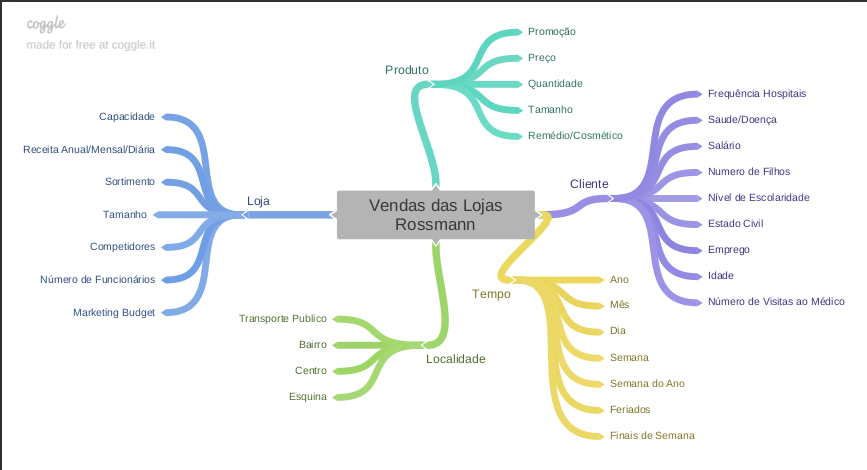

In [44]:
Image('./../images/MindMapHypothesis.png')

## 2.2 Criação das hipóteses

### 2.2.1 Hipóteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior capacidade de porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2 Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [45]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = (( df2['date'] - df2['competition_since'] ) / 30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(f'{x}-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ( (df2['date'] - df2['promo_since']) / 7 ).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x == 'a' else 'Easter holiday' if x == 'b' else 'Christmas' if x == 'c' else 'Regular day')


# 3.0 FILTRAGEM DE VARIÁVEIS

In [46]:
df3 = df2.copy()

## 3.1 Filtragem das Linhas

In [47]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Selecao das Colunas

In [48]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 ANALISE EXPLORATORIA DOS DADOS

In [49]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4.1.1 Response Variable

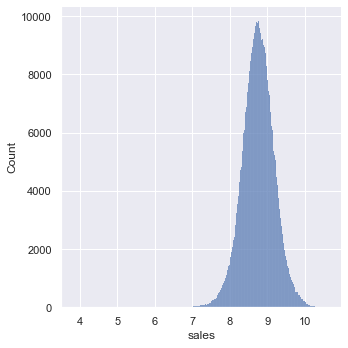

In [50]:
sns.displot( np.log1p( df4['sales'] ) )

### 4.1.2 Numerical Variable

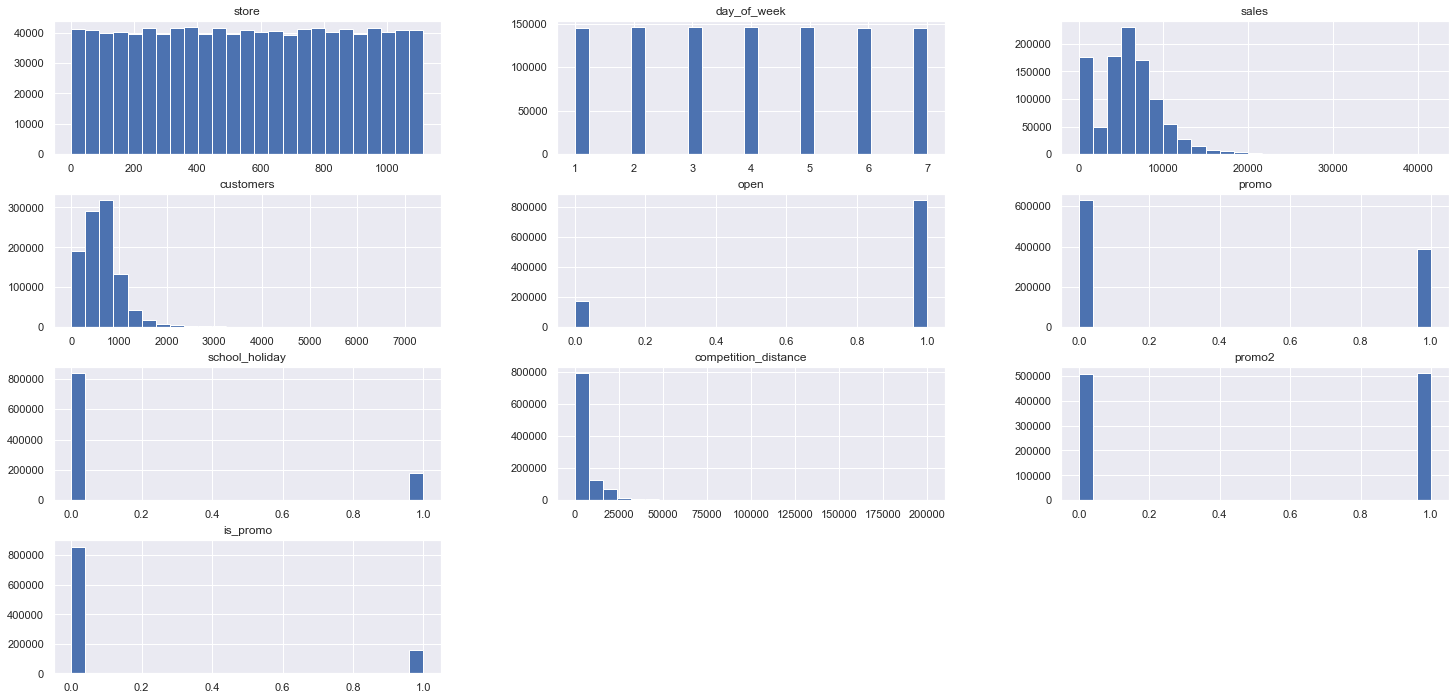

In [51]:
num_attributes.hist( bins=25 );

### 4.1.3 Categoriacal Variable

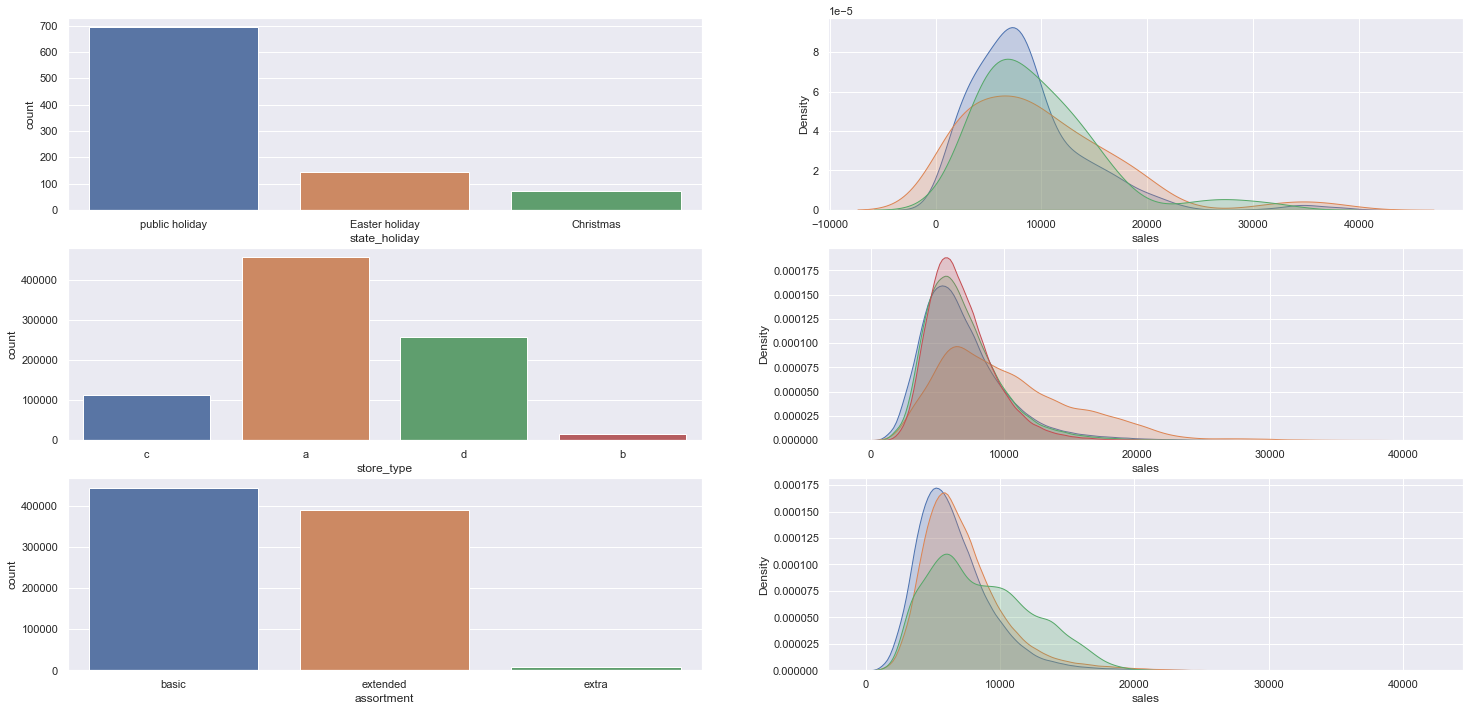

In [52]:
# state_holiday
plt.subplot( 3, 2, 1 );
a = df4[df4['state_holiday'] != 'Regular day']
sns.countplot( x='state_holiday', data=a );

plt.subplot( 3, 2, 2 );
sns.kdeplot( df4[ df4['state_holiday'] == 'public holiday']['sales'], label='public holiday', shade=True);
sns.kdeplot( df4[ df4['state_holiday'] == 'Easter holiday']['sales'], label='Easter holiday', shade=True);
sns.kdeplot( df4[ df4['state_holiday'] == 'Christmas']['sales'], label='Christmas', shade=True);

# store_type
plt.subplot(3, 2, 3);
sns.countplot(x='store_type', data=df4);

plt.subplot(3, 2, 4)
sns.kdeplot( df4[ df4['store_type'] == 'a']['sales'], label='a', shade=True);
sns.kdeplot( df4[ df4['store_type'] == 'b']['sales'], label='b', shade=True);
sns.kdeplot( df4[ df4['store_type'] == 'c']['sales'], label='c', shade=True);
sns.kdeplot( df4[ df4['store_type'] == 'd']['sales'], label='d', shade=True);

# assortment
plt.subplot(3, 2, 5)
sns.countplot(x='assortment', data=df4);

plt.subplot(3, 2, 6)
sns.kdeplot( df4[ df4['assortment'] == 'basic']['sales'], label='basic', shade=True);
sns.kdeplot( df4[ df4['assortment'] == 'extended']['sales'], label='extended', shade=True);
sns.kdeplot( df4[ df4['assortment'] == 'extra']['sales'], label='extra', shade=True);

## 4.2 Analise Bivariada

### **H1.** Lojas com maior sortimentos deveriam deveriam vender mais.
**False** => Na verdade Lojas com **MAIOR** sortimentos vendem **MENOS**.

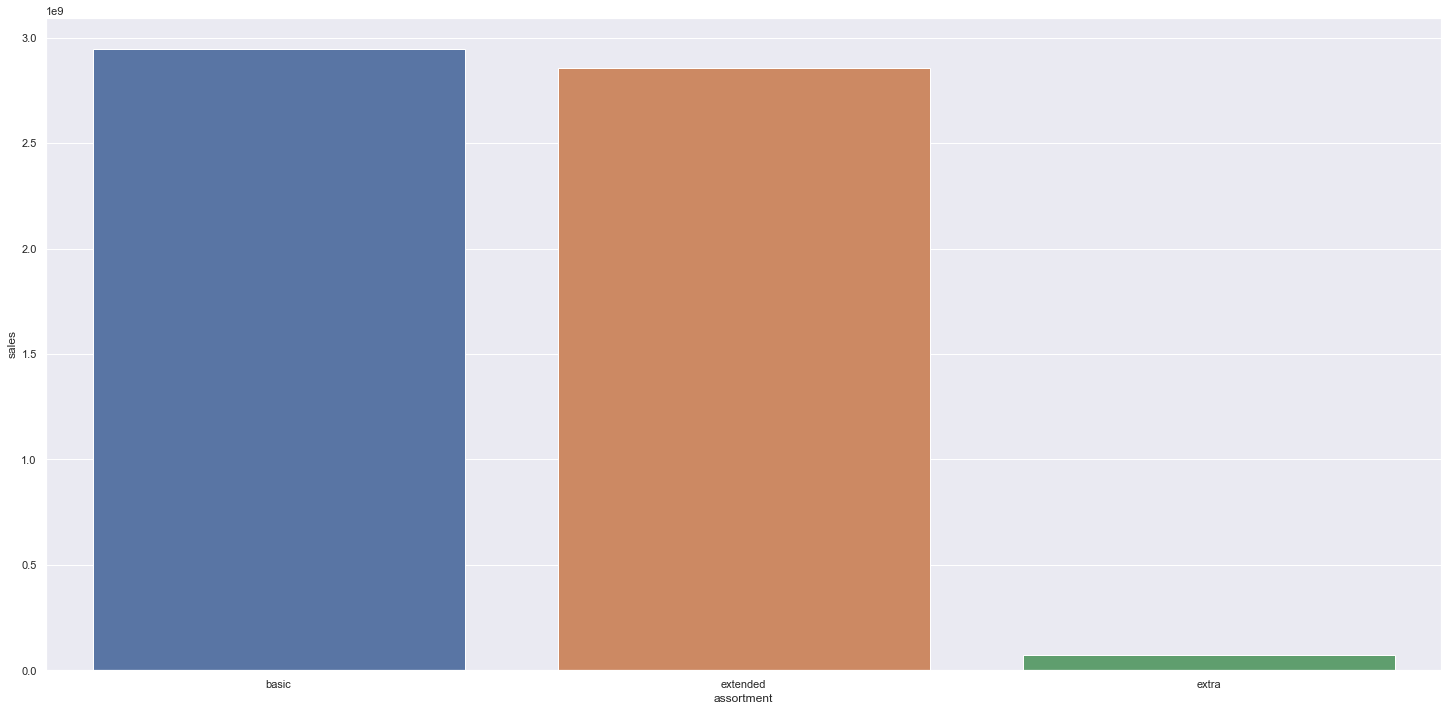

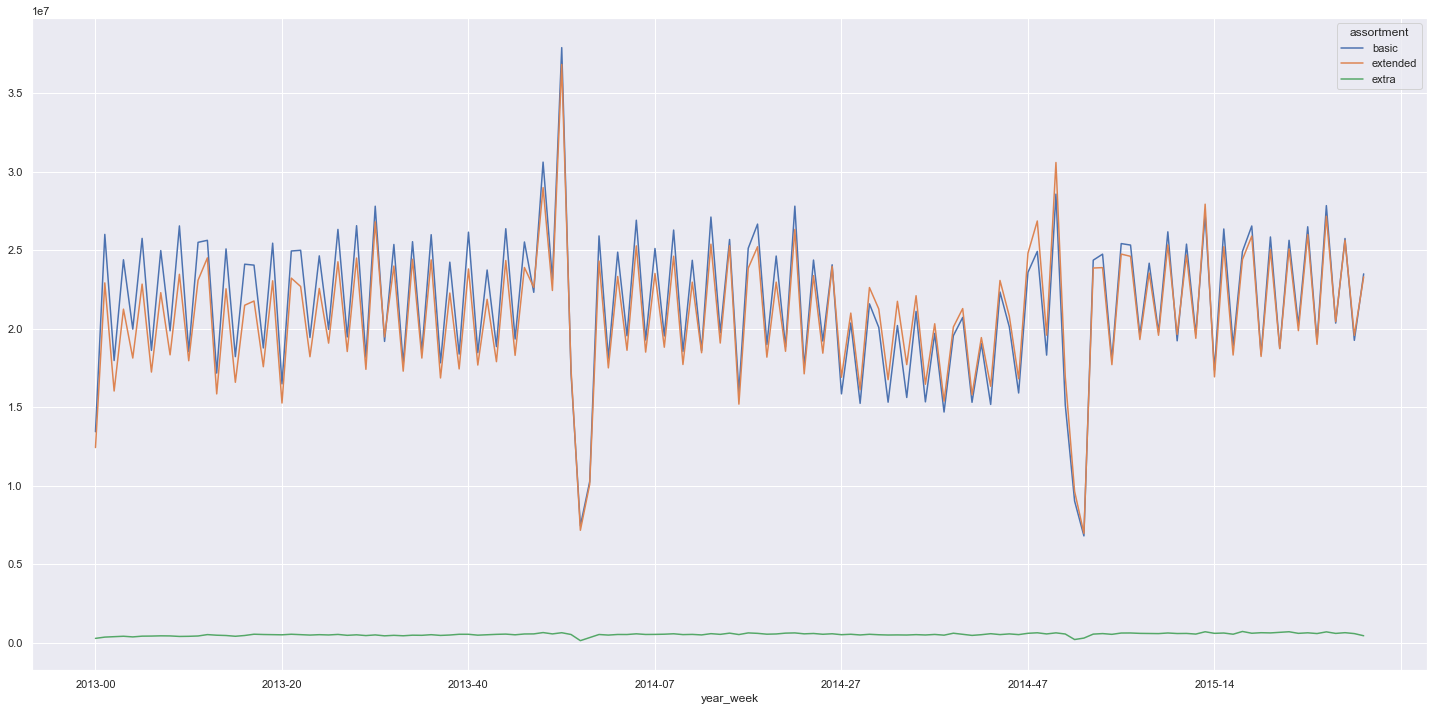

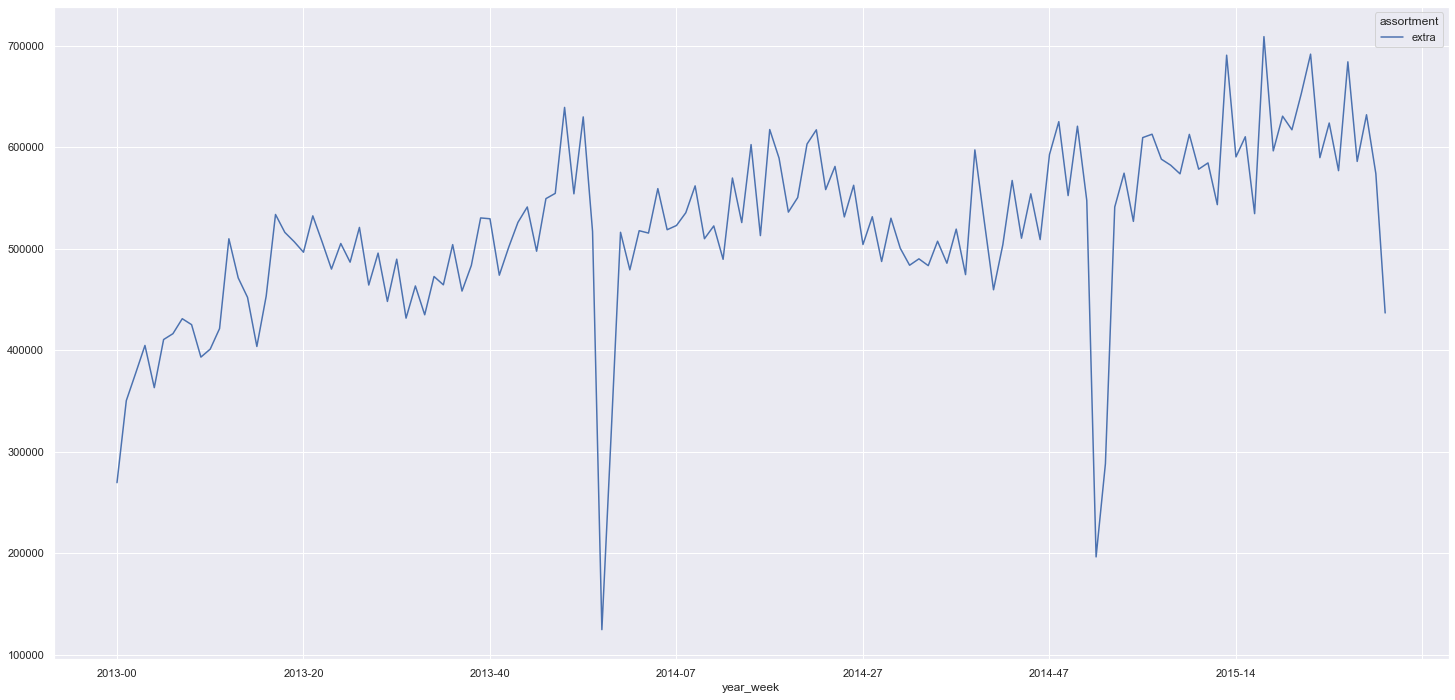

In [53]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**False** => Na verdade competidores próximos vendem **MAIS**

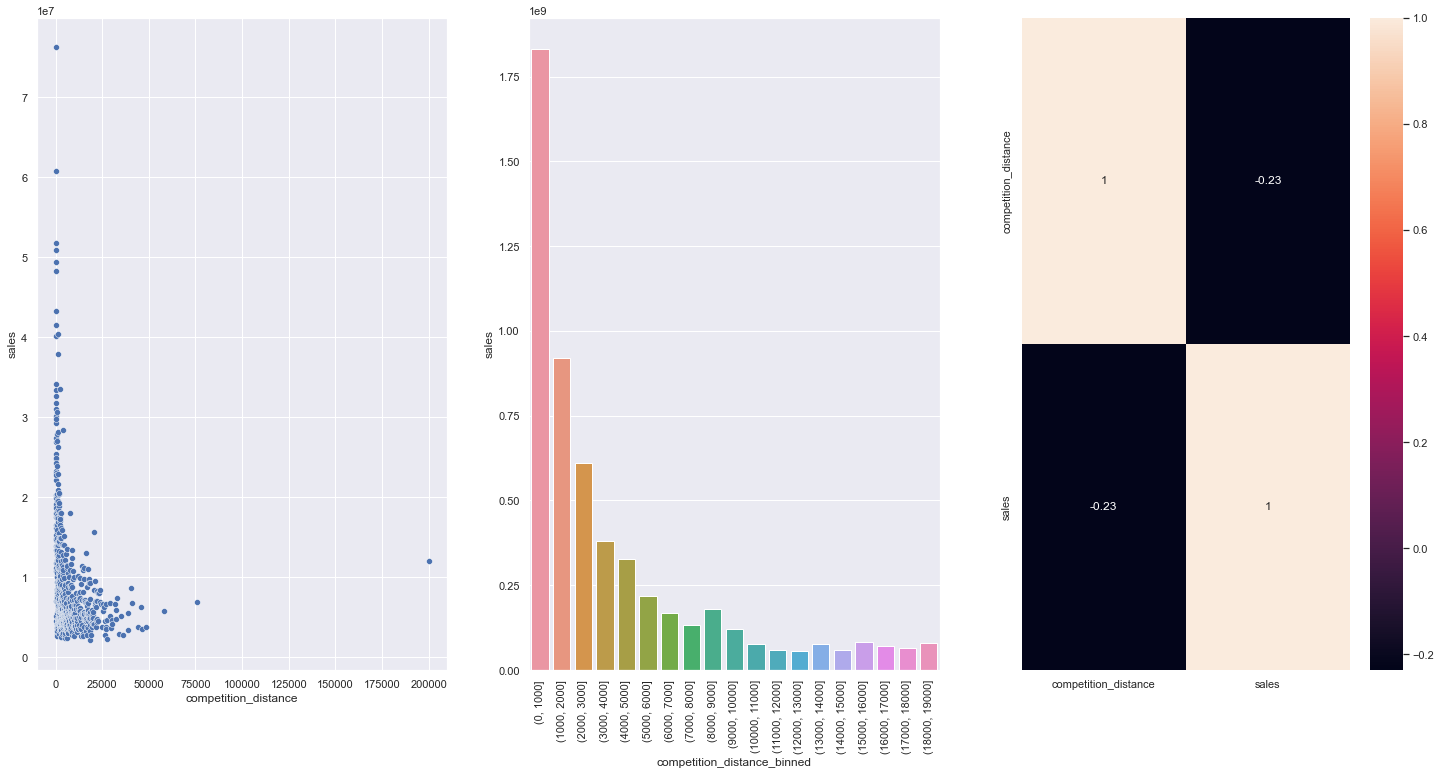

In [54]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20_000, 1_000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### **H3.** Lojas com competidores à mais tempo deveriam vender mais.
**False** => Na verdade lojas com competidores a **MENOS** tempo vendem **MAIS**

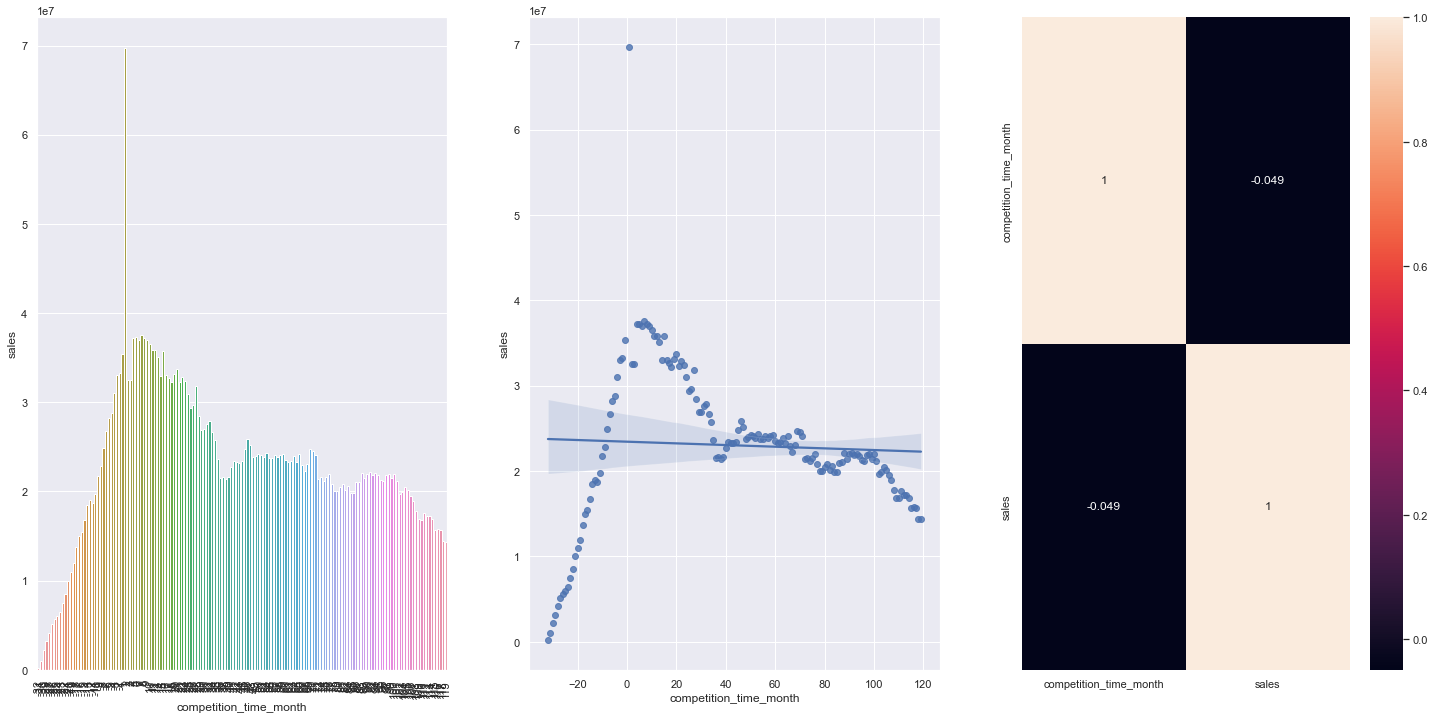

In [55]:
plt.subplot(1, 3, 1)
aux1 = df4[['sales', 'competition_time_month']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
plt.xticks(rotation=90)
sns.barplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux2.corr(method='pearson'), annot=True);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**False** => Na verdade lojas com promoções ativas por **MAIS** tempo vendem **MENOS**, depois de um certo tempo

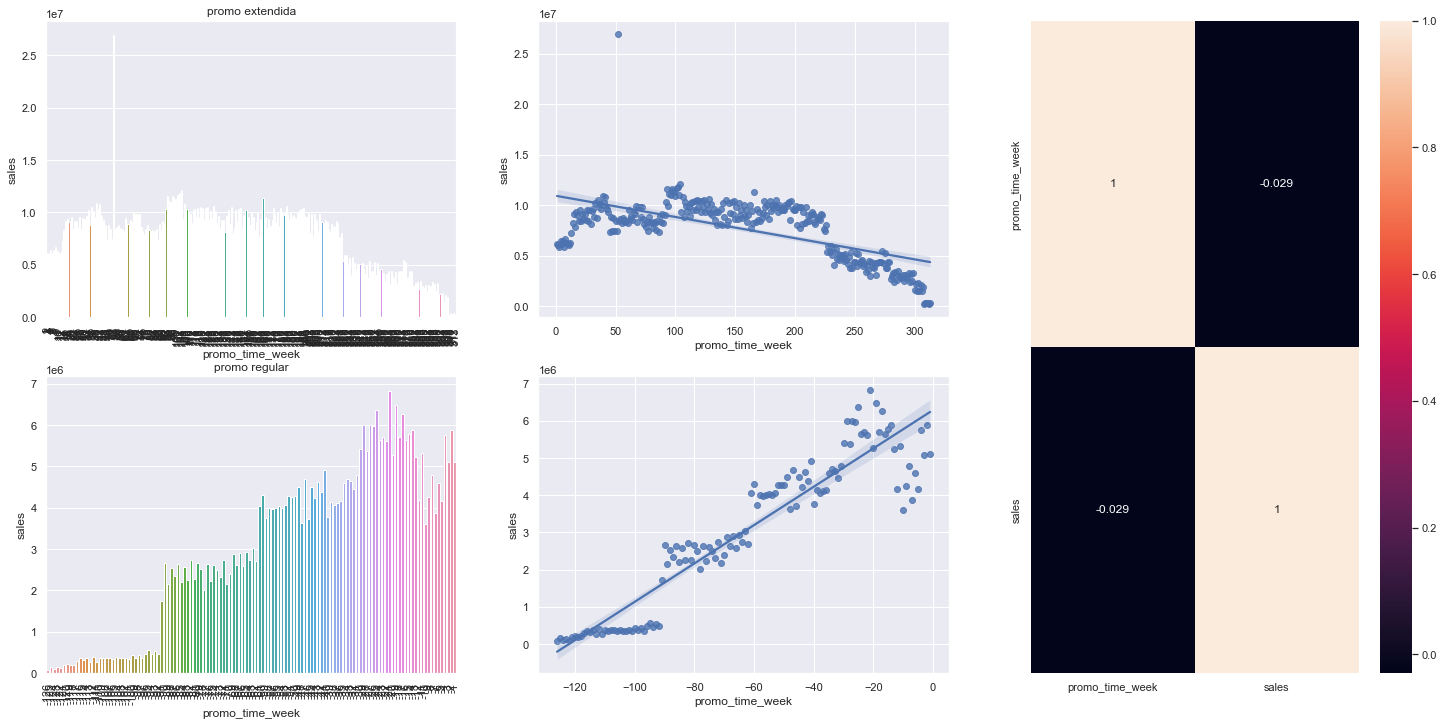

In [56]:
aux1 = df4[['sales', 'promo_time_week']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)

plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
plt.xticks(rotation=90)
plt.title('promo extendida')
sns.barplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
plt.xticks(rotation=90)
plt.title('promo regular')
sns.barplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

# correlação entre vendas e duração da promoção
plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**False** => Na verdade lojas com **MAIS** promoções consecutivas vendem **MENOS**

In [57]:
df4[['promo', 'sales', 'promo2']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


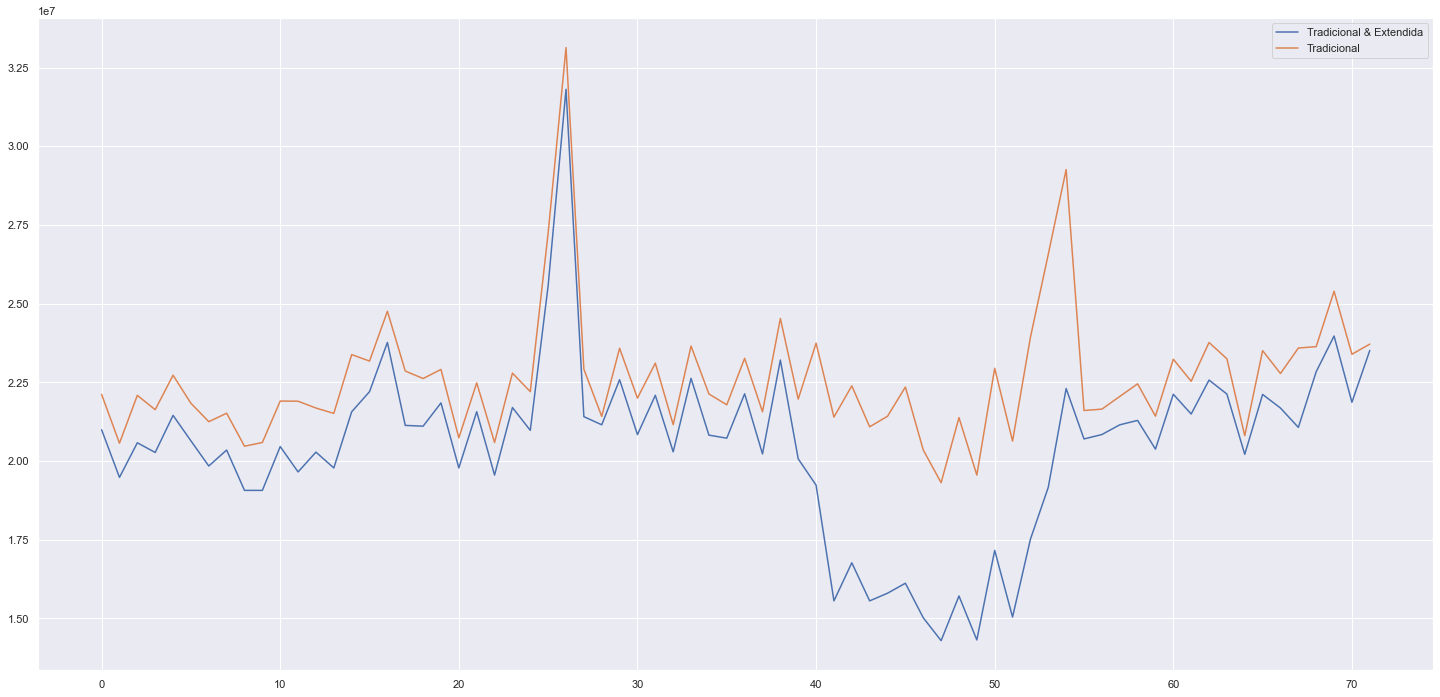

In [58]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Tradicional']);

### **H7** Lojas abertas durante o feriado de Natal deveriam vender mais.
**False** => Na verdade lojas abertas durante o feriado de Natal vendem **MENOS**

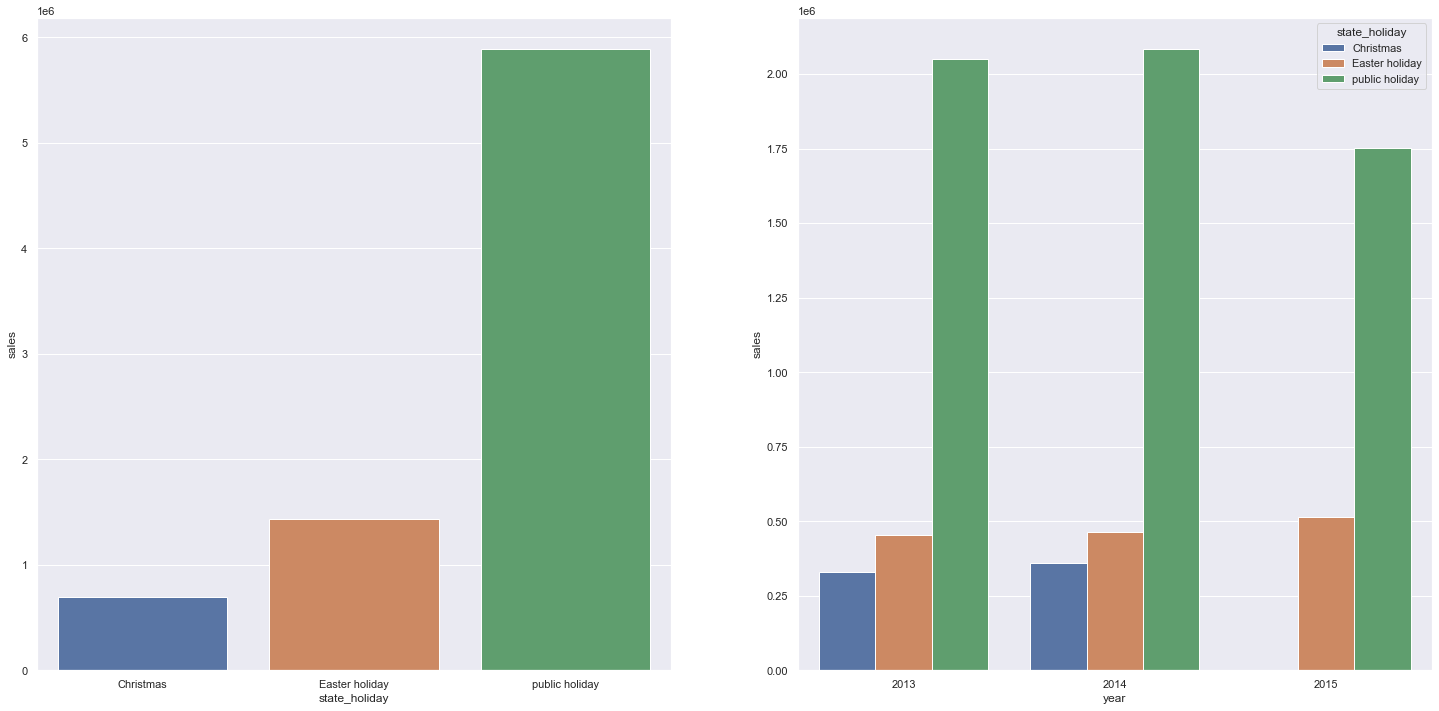

In [59]:
aux = df4[df4['state_holiday'] != 'Regular day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**False** => Na verdade lojas vendem **MENOS** ao longo dos anos.

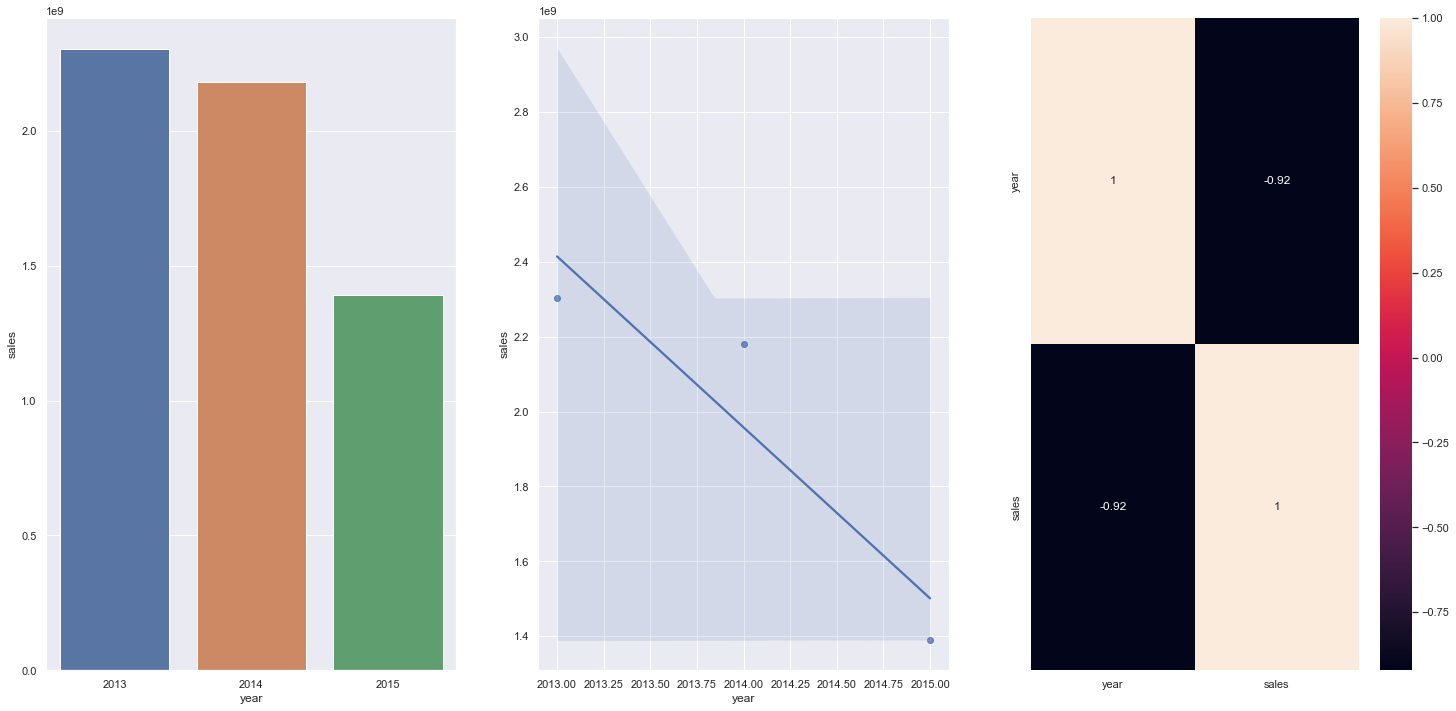

In [60]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**False** Na verdade lojas vendem **MENOS** no segundo semestre do ano.


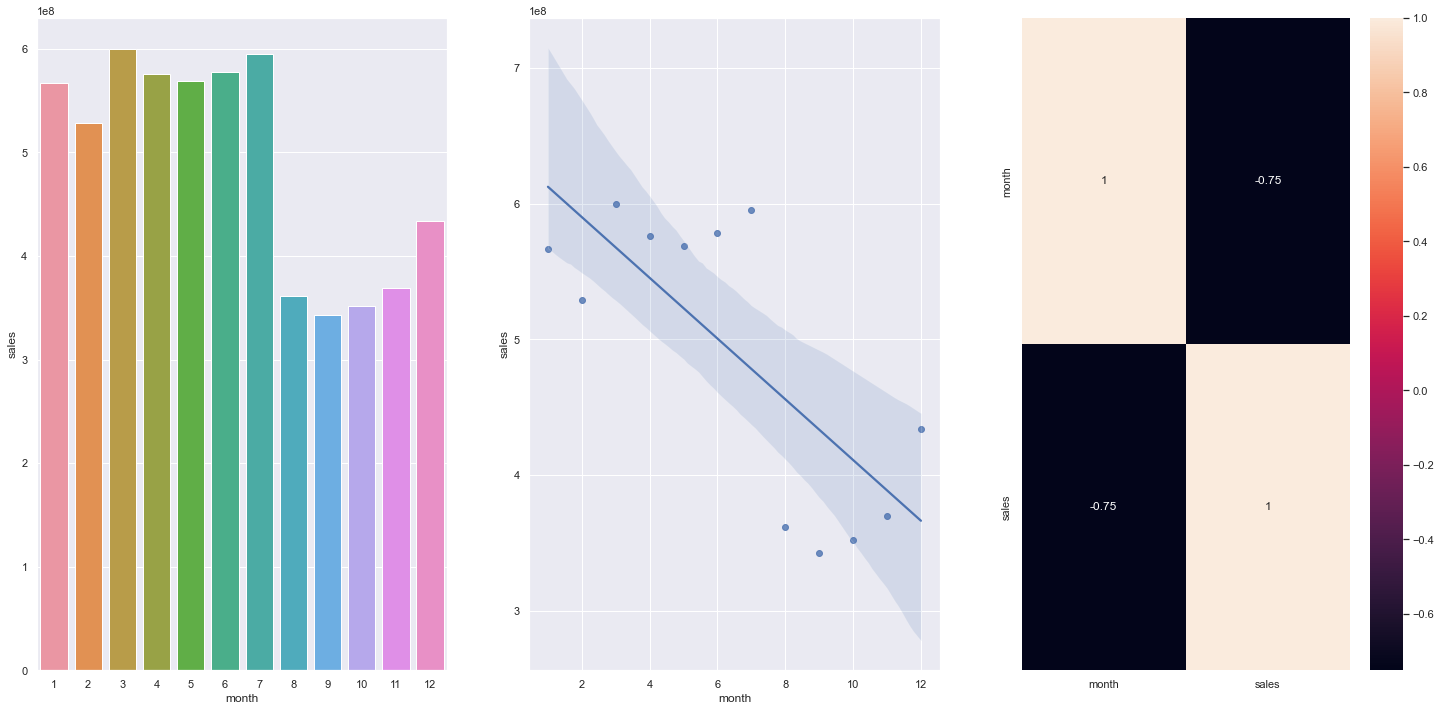

In [61]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**True** => Lojas realmente vendem mais depois do dia 10

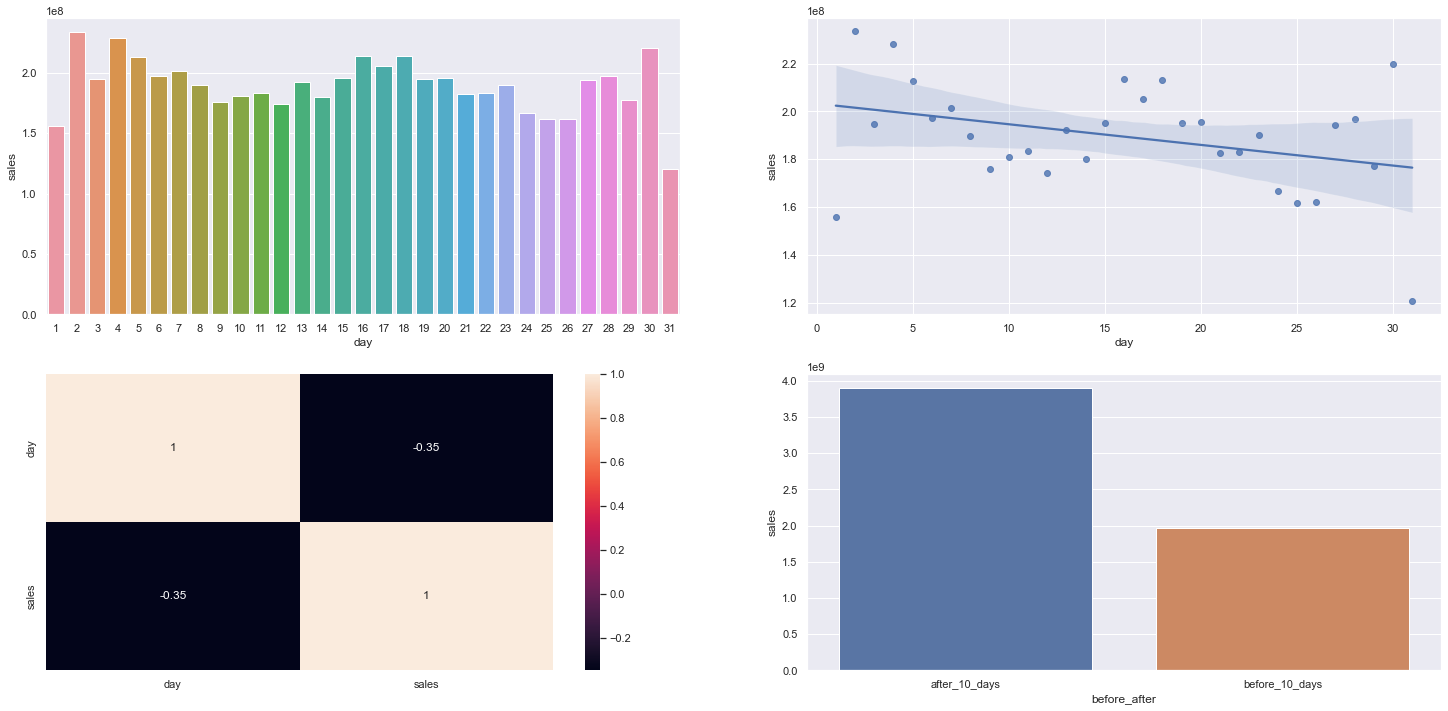

In [62]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2);

### **H11.** Lojas deveriam vender menos aos finais de semana.
**True** => Lojas vendem menos nos finais de semana

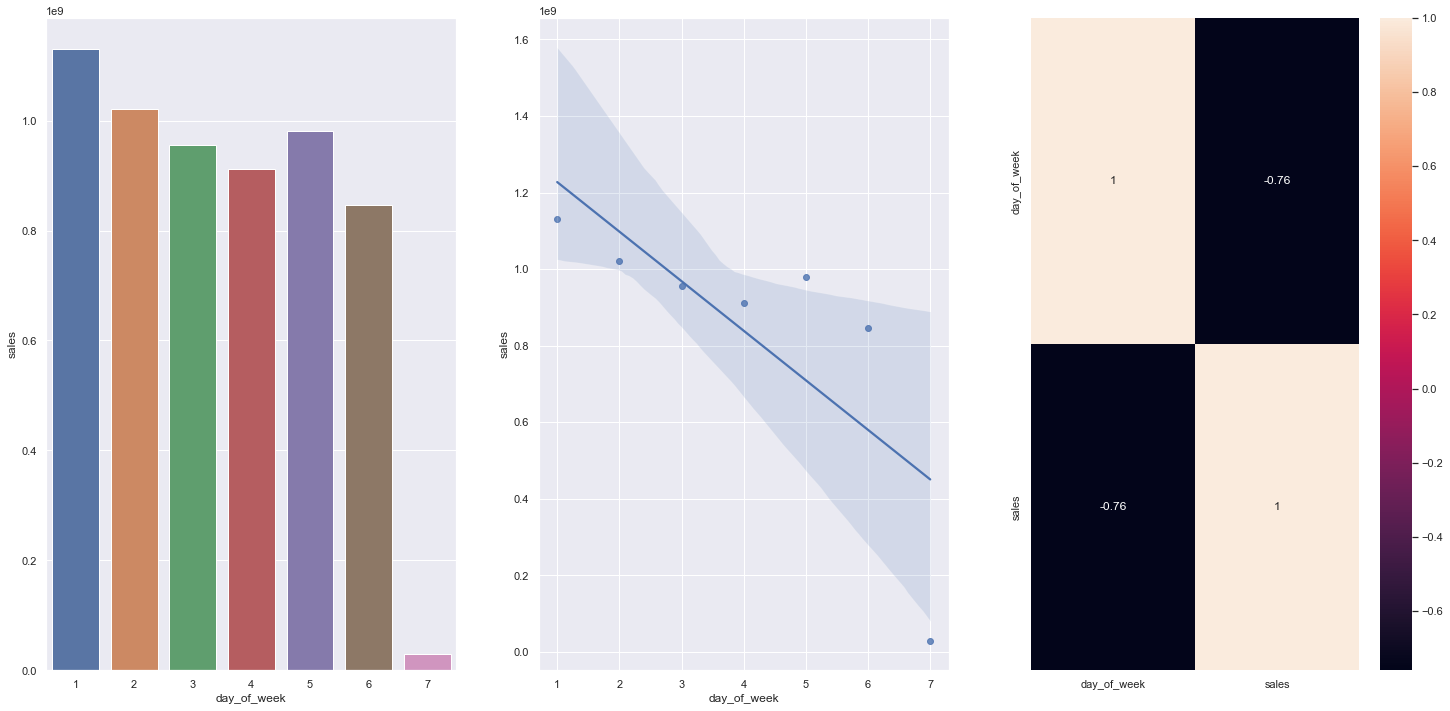

In [63]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**True** => Lojas vendem menos durante os feriados escolares, exeto os meses de julho e agosto

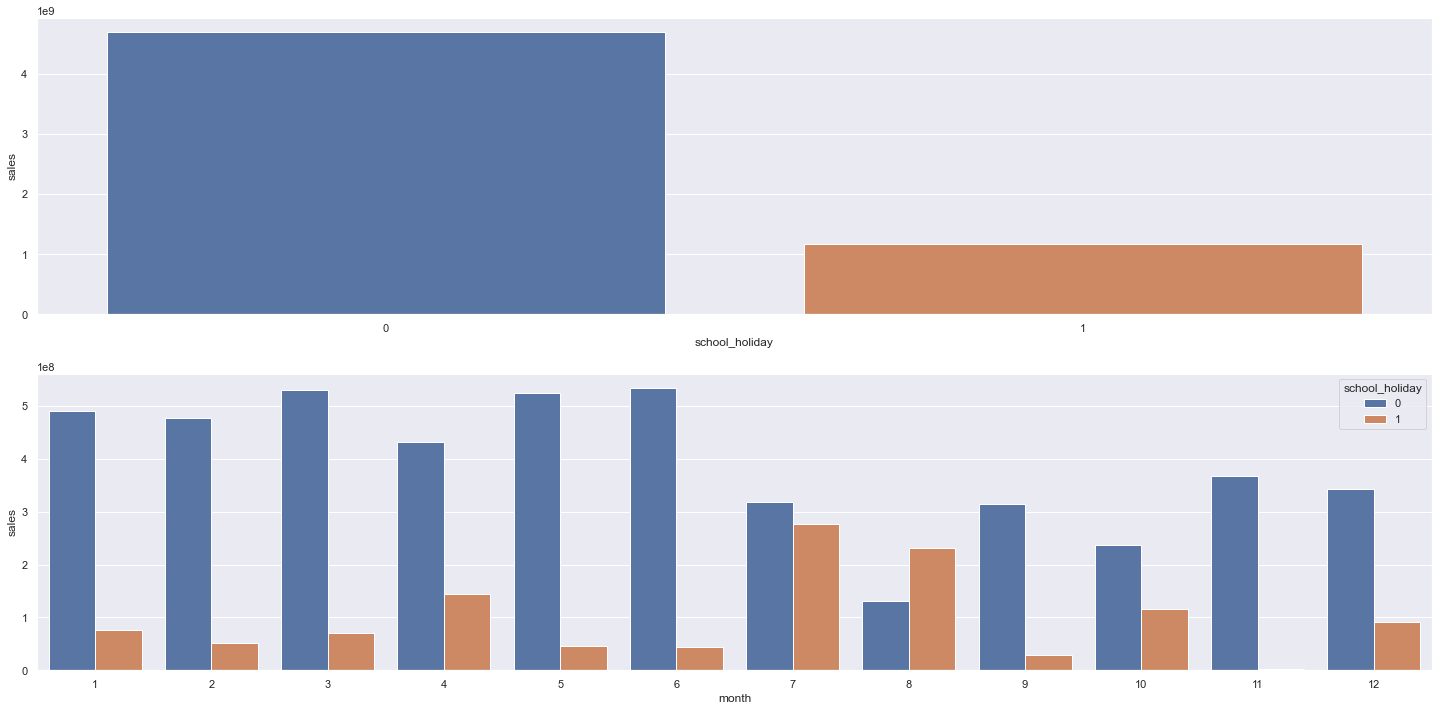

In [64]:
aux1 = df4[['sales', 'school_holiday']].groupby('school_holiday').sum().reset_index()

plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(2, 1, 2)
aux2 = df4[['sales', 'school_holiday', 'month']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

## 4.2.1. Resumo das Hipoteses

In [65]:
tab = [
    ['Hipoteses', 'Conclusão', 'Relevancia'],
    ['H1', 'Falsa', 'Baixa'],
    ['H2', 'Falsa', 'Media'],
    ['H3', 'Falsa', 'Media'],
    ['H4', 'Falsa', 'Baixa'],
    ['H5', '-', '-'],
    ['H6', 'Falsa', 'Baixa'],
    ['H7', 'Falsa', 'Media'],
    ['H8', 'Falsa', 'Alta'],
    ['H9', 'Falsa', 'Alta'],
    ['H10', 'Verdadeira', 'Alta'],
    ['H11', 'Verdadeira', 'Alta'],
    ['H12', 'Verdadeira', 'Baixa'],
]
print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusão    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Analise Multivariada

### 4.3.1 Numerical Atrributes

<AxesSubplot:>

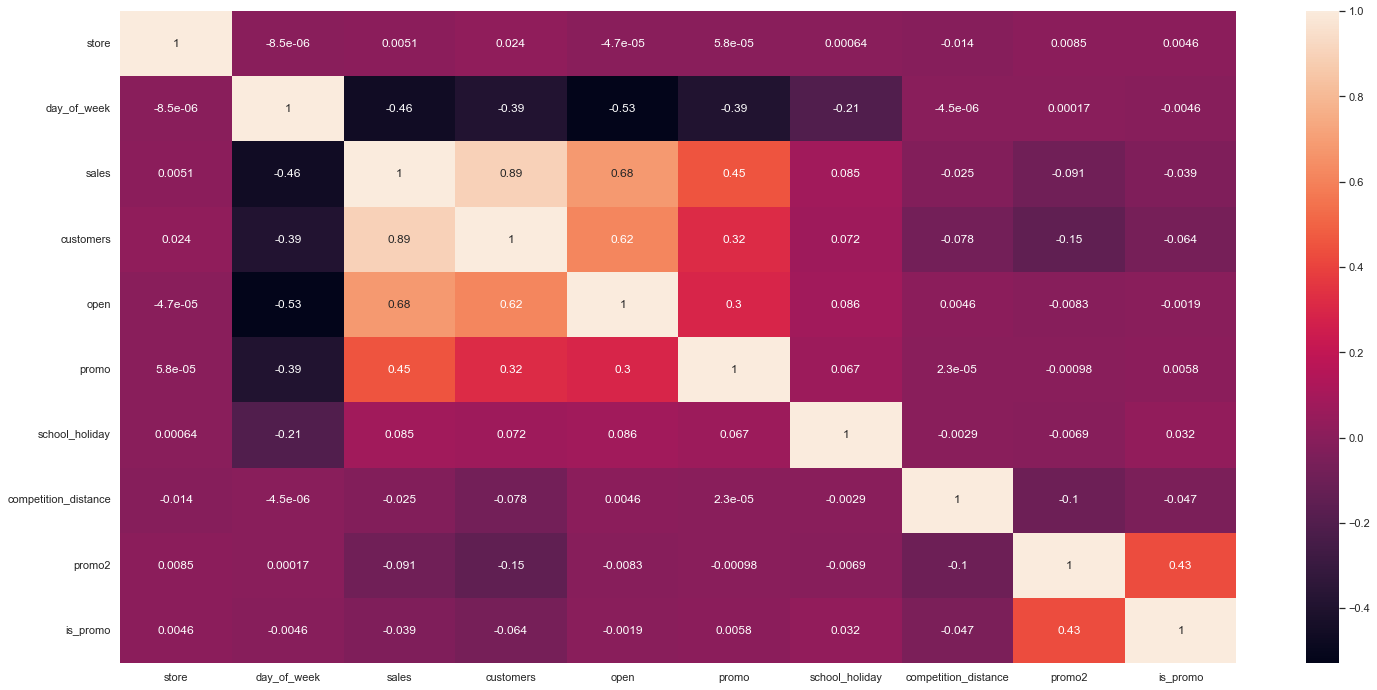

In [66]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2 Categorical Attributes


<AxesSubplot:>

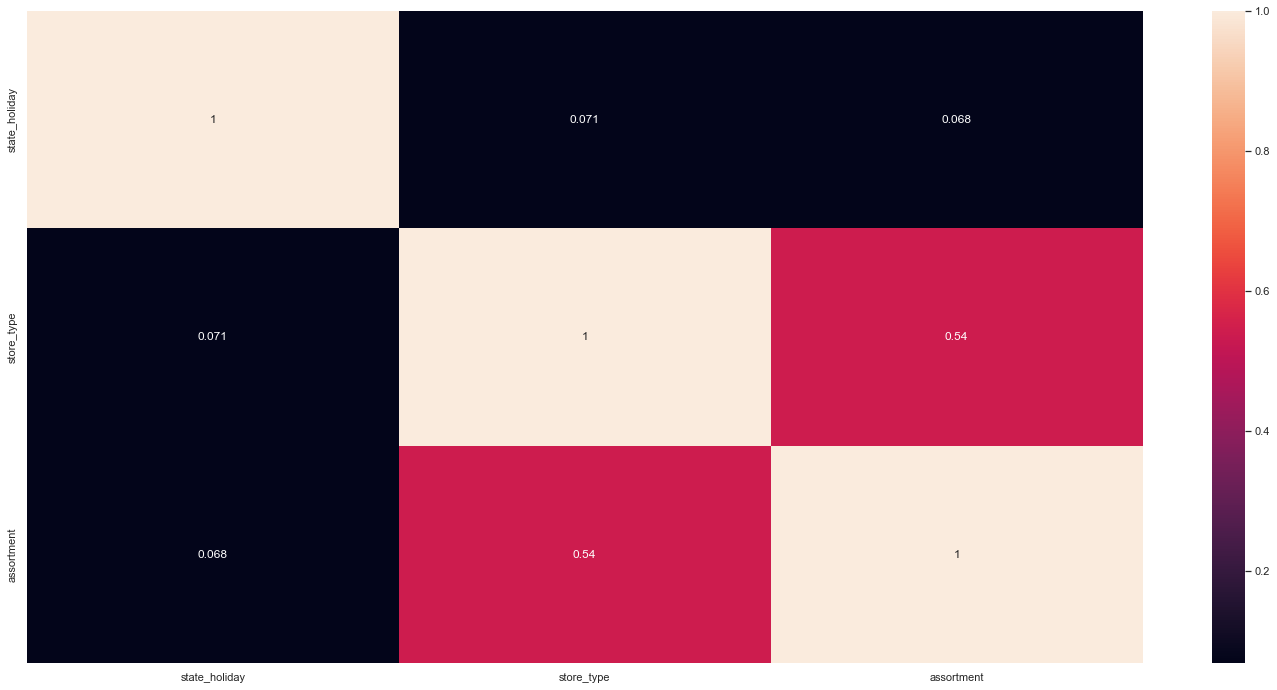

In [67]:
# only categorical data
cat = df4.select_dtypes(include='object')

# calculate cramer's V
a1 = cramer_v(cat['state_holiday'], cat['state_holiday'])
a2 = cramer_v(cat['state_holiday'], cat['store_type'])
a3 = cramer_v(cat['state_holiday'], cat['assortment'])

a4 = cramer_v(cat['store_type'], cat['state_holiday'])
a5 = cramer_v(cat['store_type'], cat['store_type'])
a6 = cramer_v(cat['store_type'], cat['assortment'])

a7 = cramer_v(cat['assortment'], cat['state_holiday'])
a8 = cramer_v(cat['assortment'], cat['store_type'])
a9 = cramer_v(cat['assortment'], cat['assortment'])

# final dataset
d = pd.DataFrame({
    'state_holiday': [a1, a2, a3],
    'store_type': [a4, a5, a6],
    'assortment': [a7, a8, a9],
})

d = d.set_index(d.columns)

# plot heatmap
sns.heatmap(d, annot=True)

# 5.0 PREPARAÇÃO DOS DADOS

In [68]:
df5 = df4.copy()

## 5.1 Normalização

## 5.2 Reescala

In [ ]:
df5['competition_time_month'] = df5['competition_time_month'].astype(np.int64)
df5['promo_time_week'] = df5['promo_time_week'].astype(np.int64)
df5['week_of_year'] = df5['week_of_year'].astype(np.int64)
df5['promo2_since_year'] = df5['promo2_since_year'].astype(np.int64)
df5['promo2_since_week'] = df5['promo2_since_week'].astype(np.int64)
df5['competition_open_since_year'] = df5['competition_open_since_year'].astype(np.int64)
df5['competition_open_since_month'] = df5['competition_open_since_month'].astype(np.int64)

In [87]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)


## 5.3 Transformação

In [ ]:
# month
# day
# week_of_year
# day_of_week